In [16]:
# Import pyomo libraries
import pandas as pd
import pyomo.environ as pe
import pyomo.gdp as pyogdp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from itertools import product

In [17]:
# Define Model
model = pe.ConcreteModel()

In [18]:
class TheatreScheduler:

    def __init__(self, case_file_path, session_file_path):
        """
        Read case and session data into Pandas DataFrames
        Args:
            case_file_path (str): path to case data in CSV format
            session_file_path (str): path to theatre session data in CSV format
        """
        try:
            self.df_cases = pd.read_csv(case_file_path)
        except FileNotFoundError:
            print("Case data not found.")

        try:
            self.df_sessions = pd.read_csv(session_file_path)
        except FileNotFoundError:
            print("Session data not found")
            
        self.model = self.create_model()
    
    def _generate_case_durations(self):
        """
        Generate mapping of cases IDs to median case time for the procedure
        Returns:
            (dict): dictionary with CaseID as key and median case time (mins) for procedure as value
        """
        #return pd.Series(self.df_cases["Median Duration"].values, index=self.df_cases["CaseID"]).to_dict()
        return pd.Series(self.df_cases["Expected Duration"].values, index=self.df_cases["CaseID"]).to_dict()

    def _generate_session_durations(self):
        """
        Generate mapping of all theatre sessions IDs to session duration in minutes
        Returns:
            (dict): dictionary with SessionID as key and session duration as value
        """
        return pd.Series(self.df_sessions["Duration"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_session_start_times(self):
        """
        Generate mapping from SessionID to session start time
        Returns:
            (dict): dictionary with SessionID as key and start time in minutes since midnight as value
        """
        # Convert session start time from HH:MM:SS format into seconds elapsed since midnight
        self.df_sessions.loc[:, "Start"] = pd.to_timedelta(self.df_sessions["Start"])
        self.df_sessions.loc[:, "Start"] = self.df_sessions["Start"].dt.total_seconds() / 60
        return pd.Series(self.df_sessions["Start"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _get_ordinal_case_deadlines(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "TargetDeadline"] = pd.to_datetime(self.df_cases["TargetDeadline"], format="%d/%m/%Y")
        self.df_cases.loc[:, "TargetDeadline"] = self.df_cases["TargetDeadline"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_cases["TargetDeadline"].values, index=self.df_cases["CaseID"]).to_dict()

    def _get_ordinal_session_dates(self):
        """
        #TODO
        Returns:

        """
        self.df_sessions.loc[:, "Date"] = pd.to_datetime(self.df_sessions["Date"], format="%d/%m/%Y")
        self.df_sessions.loc[:, "Date"] = self.df_sessions["Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_sessions["Date"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_disjunctions(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        disjunctions = []
        for (case1, case2, session) in product(cases, cases, sessions):
            if (case1 != case2) and (case2, case1, session) not in disjunctions:
                disjunctions.append((case1, case2, session))

        return disjunctions
    
    def create_model(self):
        model = pe.ConcreteModel()

        # Model Data

        # List of case IDs in surgical waiting list
        model.CASES = pe.Set(initialize=self.df_cases["CaseID"].tolist())
        # List of sessions IDs
        model.SESSIONS = pe.Set(initialize=self.df_sessions["SessionID"].tolist())
        # List of tasks - all possible (caseID, sessionID) combination
        model.TASKS = pe.Set(initialize=model.CASES * model.SESSIONS, dimen=2)
        # The duration (median case time) for each operation
        model.CASE_DURATION = pe.Param(model.CASES, initialize=self._generate_case_durations())
        # The duration of each theatre session
        model.SESSION_DURATION = pe.Param(model.SESSIONS, initialize=self._generate_session_durations())
        # The start time of each theatre session
        model.SESSION_START_TIME = pe.Param(model.SESSIONS, initialize=self._generate_session_start_times())
        # The deadline of each case
        model.CASE_DEADLINES = pe.Param(model.CASES, initialize=self._get_ordinal_case_deadlines())
        # The date of each theatre session
        model.SESSION_DATES = pe.Param(model.SESSIONS, initialize=self._get_ordinal_session_dates())


        model.DISJUNCTIONS = pe.Set(initialize=self._generate_disjunctions(), dimen=3)

        ub = 1440  # seconds in a day
        model.M = pe.Param(initialize=1e3*ub)  # big M
        max_util = 0.85
        num_cases = self.df_cases.shape[0]

        # Decision Variables
        model.SESSION_ASSIGNED = pe.Var(model.TASKS, domain=pe.Binary)
        model.CASE_START_TIME = pe.Var(model.TASKS, bounds=(0, ub), within=pe.PositiveReals)
        model.CASES_IN_SESSION = pe.Var(model.SESSIONS, bounds=(0, num_cases), within=pe.PositiveReals)

        # Objective
        def objective_function(model):
            return pe.summation(model.CASES_IN_SESSION)
            #return sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES for session in model.SESSIONS])
        model.OBJECTIVE = pe.Objective(rule=objective_function, sense=pe.maximize)

        # Constraints

        # Case start time must be after start time of assigned theatre session
        def case_start_time(model, case, session):
            return model.CASE_START_TIME[case, session] >= model.SESSION_START_TIME[session] - \
                   ((1 - model.SESSION_ASSIGNED[(case, session)])*model.M)
        model.CASE_START = pe.Constraint(model.TASKS, rule=case_start_time)

        # Case end time must be before end time of assigned theatre session
        def case_end_time(model, case, session):
            return model.CASE_START_TIME[case, session] + model.CASE_DURATION[case] <= model.SESSION_START_TIME[session] + \
                   model.SESSION_DURATION[session]*max_util + ((1 - model.SESSION_ASSIGNED[(case, session)]) * model.M)
        model.CASE_END_TIME = pe.Constraint(model.TASKS, rule=case_end_time)

        # Cases can be assigned to a maximum of one session
        def session_assignment(model, case):
            return sum([model.SESSION_ASSIGNED[(case, session)] for session in model.SESSIONS]) <= 1
        model.SESSION_ASSIGNMENT = pe.Constraint(model.CASES, rule=session_assignment)

        def set_deadline_condition(model, case, session):
            return model.SESSION_DATES[session] <= model.CASE_DEADLINES[case] + ((1 - model.SESSION_ASSIGNED[case, session])*model.M)
        model.APPLY_DEADLINE = pe.Constraint(model.TASKS, rule=set_deadline_condition)

        def no_case_overlap(model, case1, case2, session):
            return [model.CASE_START_TIME[case1, session] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M),
                    model.CASE_START_TIME[case2, session] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M)]

        model.DISJUNCTIONS_RULE = pyogdp.Disjunction(model.DISJUNCTIONS, rule=no_case_overlap)

        def theatre_util(model, session):
            return model.CASES_IN_SESSION[session] == \
                   sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES])

        model.THEATRE_UTIL = pe.Constraint(model.SESSIONS, rule=theatre_util)

        pe.TransformationFactory("gdp.bigm").apply_to(model)

        return model
    
    def solve(self, solver_name, options=None, solver_path=None, local=True):

        if solver_path is not None:
            solver = pe.SolverFactory(solver_name, executable=solver_path)
        else:
            solver = pe.SolverFactory(solver_name)

        # TODO remove - too similar to alstom
        if options is not None:
            for key, value in options.items():
                solver.options[key] = value

        if local:
            solver_results = solver.solve(self.model, tee=True)
        else:
            solver_manager = pe.SolverManagerFactory("neos")
            solver_results = solver_manager.solve(self.model, opt=solver)

        results = [{"Case": case,
                    "Session": session,
                    "Session Date": self.model.SESSION_DATES[session],
                    "Case Deadline": self.model.CASE_DEADLINES[case],
                    "Days before deadline": self.model.CASE_DEADLINES[case] - self.model.SESSION_DATES[session],
                    "Start": self.model.CASE_START_TIME[case, session](),
                    "Assignment": self.model.SESSION_ASSIGNED[case, session]()}
                   for (case, session) in self.model.TASKS]

        self.df_times = pd.DataFrame(results)

        all_cases = self.model.CASES.value_list
        cases_assigned = []
        for (case, session) in self.model.SESSION_ASSIGNED:
            if self.model.SESSION_ASSIGNED[case, session] == 1:
                cases_assigned.append(case)

        cases_missed = list(set(all_cases).difference(cases_assigned))
        print("Number of cases assigned = {} out of {}:".format(len(cases_assigned), len(all_cases)))
        print("Cases assigned: ", cases_assigned)
        print("Number of cases missed = {} out of {}:".format(len(cases_missed), len(all_cases)))
        print("Cases missed: ", cases_missed)
        self.model.CASES_IN_SESSION.pprint()
        print("Total Objective = {}".format(sum(self.model.CASES_IN_SESSION.get_values().values())))
        print("Number of constraints = {}".format(solver_results["Problem"].__getitem__(0)["Number of constraints"]))
        #self.model.SESSION_ASSIGNED.pprint()
        print(self.df_times[self.df_times["Assignment"] == 1].to_string())
        self.draw_gantt()

    def draw_gantt(self):

        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))

        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    xs = df.loc[(c, s), 'Start'] /60
                    xf = (df.loc[(c, s), 'Start'] + self.df_cases[self.df_cases["CaseID"] == c]["Expected Duration"])/60
                    ax.plot([xs, xf], [s] * 2, c=colors[c_ix % 7], **bar_style)
                    ax.text((xs + xf) / 2, s, c, **text_style)

        ax.set_title('Assigning Ophthalmology Cases to Theatre Sessions')
        ax.set_xlabel('Time')
        ax.set_ylabel('Sessions')
        ax.grid(True)

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        fig.tight_layout()
        plt.show()

In [19]:
# Import cases and sessions data into pyomo model
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "cases.csv")
session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions.csv")
options = {"seconds": 60}
scheduler = TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Program Files\Cbc-releases.2.10.8-w64-msvc16-md\bin\cbc.exe -seconds 60 -printingOptions all -import C:\Users\liuda\AppData\Local\Temp\tmp8etlw_9c.pyomo.lp -stat=1 -solve -solu C:\Users\liuda\AppData\Local\Temp\tmp8etlw_9c.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 60
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve is modifying 8 integer bounds and re-presolving
Presolve 2972 (-2643) rows, 1578 (-2147) columns and 14188 (-7537) elements
Statistics for presolved model
Original problem has 3592 integers (3592 of which binary)
Presolved problem has 1472 integers (1472 of which binary)
==== 1472 zero objective 2 different
1472 variables have objective of -0
106 variables have objective of 1
==== absolute objective values 2 di

Cbc0010I After 2700 nodes, 1218 on tree, -27 best solution, best possible -30 (6.43 seconds)
Cbc0010I After 2800 nodes, 1265 on tree, -27 best solution, best possible -30 (6.62 seconds)
Cbc0010I After 2900 nodes, 1322 on tree, -27 best solution, best possible -30 (6.79 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 195 rows 62 columns
Cbc0010I After 3000 nodes, 1368 on tree, -27 best solution, best possible -30 (6.96 seconds)
Cbc0010I After 3100 nodes, 1414 on tree, -27 best solution, best possible -30 (7.10 seconds)
Cbc0010I After 3200 nodes, 1465 on tree, -27 best solution, best possible -30 (7.21 seconds)
Cbc0010I After 3300 nodes, 1497 on tree, -27 best solution, best possible -30 (7.35 seconds)
Cbc0010I After 3400 nodes, 1524 on tree, -27 best solution, best possible -30 (7.49 seconds)
Cbc0010I After 3500 nodes, 1573 on tree, -27 best solution, best possible -30 (7.67 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 199 rows 66 columns
Cbc0010I 

Cbc0010I After 14900 nodes, 4016 on tree, -28 best solution, best possible -30 (25.66 seconds)
Cbc0010I After 15000 nodes, 4055 on tree, -28 best solution, best possible -30 (25.79 seconds)
Cbc0010I After 15100 nodes, 4104 on tree, -28 best solution, best possible -30 (25.95 seconds)
Cbc0010I After 15200 nodes, 4157 on tree, -28 best solution, best possible -30 (26.08 seconds)
Cbc0010I After 15300 nodes, 4210 on tree, -28 best solution, best possible -30 (26.20 seconds)
Cbc0010I After 15400 nodes, 4264 on tree, -28 best solution, best possible -30 (26.32 seconds)
Cbc0010I After 15500 nodes, 4322 on tree, -28 best solution, best possible -30 (26.44 seconds)
Cbc0010I After 15600 nodes, 4379 on tree, -28 best solution, best possible -30 (26.60 seconds)
Cbc0010I After 15700 nodes, 4431 on tree, -28 best solution, best possible -30 (26.74 seconds)
Cbc0010I After 15800 nodes, 4483 on tree, -28 best solution, best possible -30 (26.85 seconds)
Cbc0010I After 15900 nodes, 4537 on tree, -28 best

Cbc0010I After 23500 nodes, 6075 on tree, -28 best solution, best possible -30 (43.87 seconds)
Cbc0010I After 23600 nodes, 6078 on tree, -28 best solution, best possible -30 (44.17 seconds)
Cbc0010I After 23700 nodes, 6083 on tree, -28 best solution, best possible -30 (44.43 seconds)
Cbc0010I After 23800 nodes, 6127 on tree, -28 best solution, best possible -30 (44.56 seconds)
Cbc0010I After 23900 nodes, 6187 on tree, -28 best solution, best possible -30 (44.66 seconds)
Cbc0010I After 24000 nodes, 6209 on tree, -28 best solution, best possible -30 (44.94 seconds)
Cbc0010I After 24100 nodes, 6208 on tree, -28 best solution, best possible -30 (45.29 seconds)
Cbc0010I After 24200 nodes, 6204 on tree, -28 best solution, best possible -30 (45.68 seconds)
Cbc0010I After 24300 nodes, 6204 on tree, -28 best solution, best possible -30 (46.03 seconds)
Cbc0010I After 24400 nodes, 6238 on tree, -28 best solution, best possible -30 (46.18 seconds)
Cbc0010I After 24500 nodes, 6278 on tree, -28 best

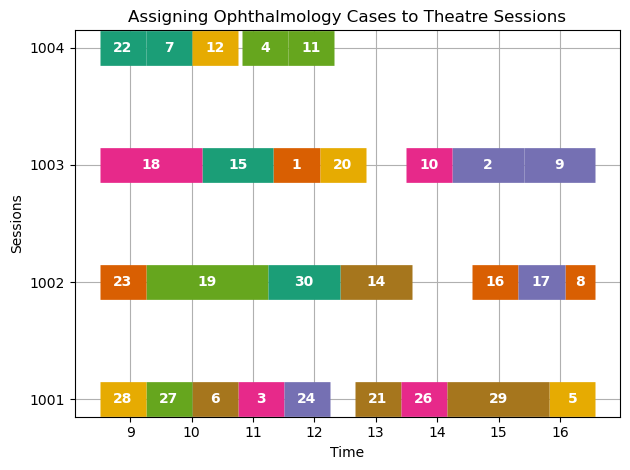

In [20]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)

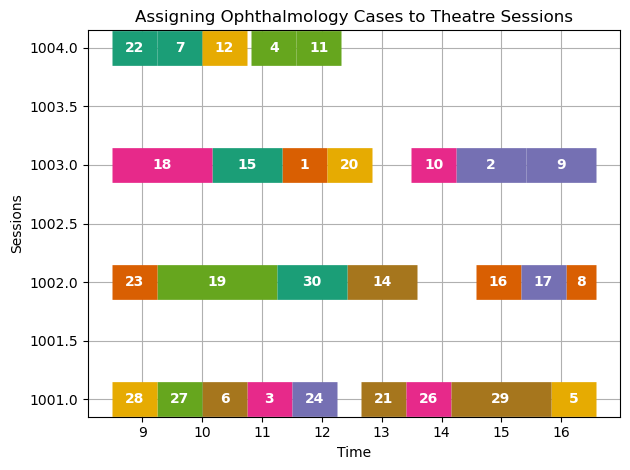

In [15]:
scheduler.draw_gantt()